# Modelo de explicações contra-factuais

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## Preparando os dados

In [2]:
df = pd.read_csv('../../data/final_features_df.csv')
df.head()

,Unnamed: 0,Age,Income,faves_pca0,faves_pca1,unfaves_pca0,unfaves_pca1,accessories,alcohol,animamted,...,Drama.2,Entertainment (Variety Shows),Factual,Learning,Music,News,Religion &amp; Ethics,Sport.1,Weather,Rating_bin
0,0,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,1,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,2,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,3,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,4,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [3]:
df = df.fillna(0)
y = df['Rating_bin']
X = df.drop(columns=['Unnamed: 0', 'Rating_bin', 'Gender_F'])

X.head()

,Age,Income,faves_pca0,faves_pca1,unfaves_pca0,unfaves_pca1,accessories,alcohol,animamted,animated,...,Comedy.1,Drama.2,Entertainment (Variety Shows),Factual,Learning,Music,News,Religion &amp; Ethics,Sport.1,Weather
0,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
1,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
2,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
3,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
4,62,1,-0.321485,0.0786,-0.19967,-0.200645,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.85)

## Treinando o modelo

In [5]:
clf_logreg = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
grid = GridSearchCV(
  clf_logreg,
  param_grid={'C': np.logspace(-5, 5, num=10)},
  cv=5,
  scoring='f1_micro',
)
grid.fit(X_train, y_train)
clf_logreg = grid.best_estimator_

/home/delucca/.cache/pypoetry/virtualenvs/mo810-MtB-mBzd-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/delucca/.cache/pypoetry/virtualenvs/mo810-MtB-mBzd-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

In [6]:
y_pred = clf_logreg.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.92      0.69      0.79      4635
           1       0.26      0.66      0.38       783

    accuracy                           0.69      5418
   macro avg       0.59      0.67      0.58      5418
weighted avg       0.83      0.69      0.73      5418



array([[3203, 1432],
       [ 269,  514]])

In [7]:
f1_score(y_test, y_pred)

0.37669475998534263

## Preparando os classificadores

In [8]:
from cfmining.predictors import MonotoneClassifier

# Aqui, estamos utilizando o threshold que iguala a proporções de 1 que encontramos no T3
prob = 0.187
clf_logreg_ = MonotoneClassifier(clf_logreg, X_train, y_train, threshold=prob)
coefficients = clf_logreg.coef_[0]
intercept = clf_logreg.intercept_[0]

### Criando o ActionSet e selecionando uma pessoa

In [17]:
from cfmining.action_set import ActionSet

action_set = ActionSet(X=X, default_bounds=(0, 100, 'percentile'))
action_set.embed_linear_clf(coefficients=coefficients)

for feat in action_set:
    feat.step_type ="relative"
    feat.step_size = 0.1
    feat.update_grid()

In [28]:
columns = X.columns
mutable_columns = [
    'Age',
    'Income',
    'Gender_M',
    'Home country_Canada',
    'Home country_Czech Republic',
    'Home country_Great Britain',
    'Home country_India',
    'Home country_Italy',
    'Home country_Phillipines',
    'Home country_Romania',
    'Home country_Saudi Arabia',
    'Home country_Singapore',
    'Home country_Slovenia',
    'Home country_United Kingdom',
    'Home country_United States of America',
]

for column in columns:
    if column not in mutable_columns:
        action_set[column].mutable = False

In [29]:
pd_coef = pd.Series(coefficients, index=X.columns).to_frame('Coefficients')
pd_coef

,Coefficients
Age,-0.014149
Income,0.098844
faves_pca0,-0.109927
faves_pca1,0.149764
unfaves_pca0,0.017198
...,...
Music,0.284487
News,0.139060
Religion &amp; Ethics,-0.015743
Sport.1,0.103427


In [30]:
scores = pd.Series(clf_logreg.predict_proba(X)[:, 1])
denied_individuals = scores.loc[lambda s: (s < prob)].index

In [31]:
choice = np.random.choice(denied_individuals)
print('Choice:', choice)
individual = X.loc[choice].values

Choice: 28980


## Avaliando o contrafactual

In [32]:
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion
from cfmining.mip_builder import RecourseBuilder

percCalc = PercentileCalculator(action_set=action_set)
percCriteria = PercentileCriterion(individual, percCalc)
percChCriteria = PercentileChangesCriterion(individual, percCalc)


p = prob
rb = RecourseBuilder(
      optimizer="cplex",
      coefficients=coefficients,
      intercept=intercept-(np.log(p/(1.-p))),
      action_set=action_set,
      x=individual,
)

build_info, indices = rb._get_mip_build_info()
output_1 = rb.fit()

In [33]:
num_of_actions = sum(output_1['actions']!=0)
print('Number of actions', num_of_actions)
(pd.Series(output_1['actions']+individual, index=X.columns).iloc[output_1['actions']!=0].to_frame('Actions')).replace(0,'-')

Number of actions 5


,Actions
Age,38.0
Home country_Czech Republic,1.0
Home country_India,1.0
Home country_Italy,1.0
Home country_Romania,1.0


In [34]:
from cfmining.algorithms import MAPOCAM
import warnings

en_nd_feat = MAPOCAM(action_set, individual, clf_logreg_)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    en_nd_feat.fit()

## Visualizando

In [35]:
from cfmining.visualization import buildTable, PlotCounterfactuals

names = action_set.df['name'].values
overview_clean = buildTable(en_nd_feat, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_nd_feat, individual, percCriteria, names, include_original=True, include_cost=True)

In [36]:
overview_full.replace(np.nan, '-')

,Orig,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21
Age,46.0,38.0,33.0,38.0,-,28.0,-,43.0,33.0,28.0,...,33.0,28.0,-,43.0,33.0,-,18.0,43.0,-,38.0
Income,0.0,-,-,-,-,-,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,-,3.0,3.0,3.0
faves_pca0,-0.191823,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
faves_pca1,-0.022644,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
unfaves_pca0,-0.037062,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
News,0.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Religion &amp; Ethics,0.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Sport.1,0.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Weather,0.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


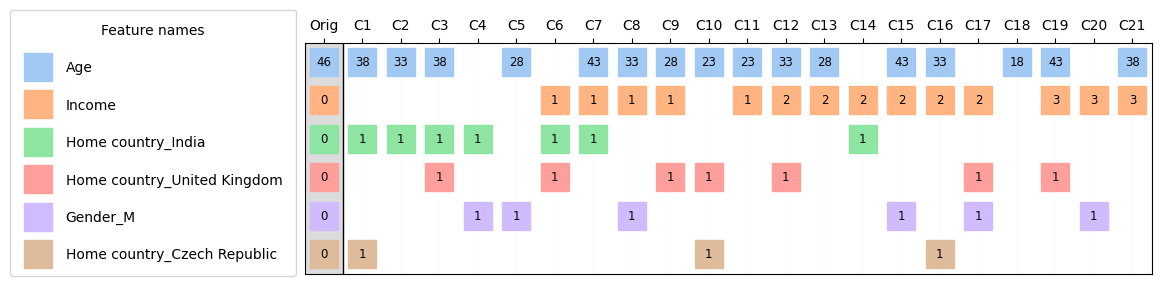

In [37]:
pltW = PlotCounterfactuals(overview_clean.iloc[:,:], individual)
pltW.show(None, bbox_to_anchor=(-0.01, -0.01))